In [1]:
# coding: utf-8

import math
from DQN import *
import numpy as np
import torch
%matplotlib inline


In [2]:
training_config = load_config("config.yml")["training_config"]

seed = training_config["random_seed"]
n_episodes = training_config["n_episodes"]
max_episode_step = training_config["max_episode_step"]
torch.manual_seed(seed)
np.random.seed(seed)

env_id ="Qube-v0" # "CartPole-v0"
env = GentlyTerminating(gym.make(env_id))




In [3]:
print_config()

************************
*** model configuration: ***
load_model: true
model_path: storage/test.ckpt
n_actions: 11
n_hidden: 1
size_hidden: 256
use_cuda: true

*** training configuration: ***
batch_size: 64
gamma: 0.99
learning_rate: 0.0003
max_episode_step: 500
memory_size: 100000
n_episodes: 1000
random_seed: 1234

************************


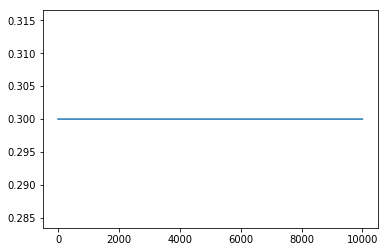

In [6]:
epsilon_start = 0.9
epsilon_final = 0.02
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final +(epsilon_start - epsilon_final) * np.exp(-1. * frame_idx / epsilon_decay)
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [ ]:


policy = Policy(env)
losses = []
all_rewards = []
avg_rewards = []

for i_episode in range(n_episodes):
    episode_reward = 0
    state = env.reset()
    state[4:6]/=20

    for step in range(max_episode_step):
        env.render()
        epsilon = 0.3 #epsilon_by_frame(frame_idx)

        action = policy.act(state, epsilon)

        f_action = 5*(action-(policy.n_actions-1)/2)/((policy.n_actions-1)/2)
        next_state, reward, done, _ = env.step(f_action)

        reward = 100*(reward-0.005)
        next_state[4:6]/=20

        policy.replay_buffer.push(state, action[0], reward, next_state, done)

        state = next_state
        episode_reward += reward

        if done:
            break

        if len(policy.replay_buffer) > policy.batch_size:
            loss = policy.train()
            losses.append(loss.item())

    all_rewards.append(episode_reward)
    avg_rewards.append(np.mean(all_rewards[-10:]))
    episode_reward = 0
    if i_episode % 1 == 0:
        save_fig(i_episode, all_rewards,avg_rewards, losses)

    if i_episode % 2 == 0:
        policy.update_target()

    policy.save_model("storage/test.ckpt")

env.close()
